In [1]:
!pip -q install -U transformers bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.7 MB/s eta 0:00:00


In [2]:
import torch
from transformers import BertTokenizer, BertModel

# We will optionally import visualization tools in later cells
# so this cell stays focused on model setup.

# Use GPU if available for faster inference (not required for attention)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
MODEL_NAME = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Setting output_attentions=True returns a tuple of attention tensors (one per layer)
model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
model.to(device)
model.eval();  # eval mode disables dropout etc. for consistent outputs


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
text = "He went to the bank to deposit money."
# Note: BERT uses special tokens [CLS] at start and [SEP] at end.
# Tokenization splits words into WordPiece tokens when necessary.

encoded = tokenizer(
    text,
    return_tensors="pt",
    add_special_tokens=True,   # adds [CLS] and [SEP]
)

# Move tensors to the same device as the model (CPU/GPU)
encoded = {k: v.to(device) for k, v in encoded.items()}

# Convert ids back to tokens so we can label axes in visualizations
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
tokens


['[CLS]',
 'he',
 'went',
 'to',
 'the',
 'bank',
 'to',
 'deposit',
 'money',
 '.',
 '[SEP]']

In [5]:
with torch.no_grad():
    outputs = model(**encoded)

attentions = outputs.attentions  # tuple of length = num_layers
num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[2]

print(f"Layers: {num_layers}, Heads per layer: {num_heads}, Seq len: {seq_len}")
print(f"Attention[0] shape: {attentions[0].shape}  # (batch, heads, seq, seq)")


Layers: 12, Heads per layer: 12, Seq len: 11
Attention[0] shape: torch.Size([1, 12, 11, 11])  # (batch, heads, seq, seq)


In [6]:
from bertviz import head_view

# For single-sentence input, sentence_b_start=None is fine.
# For sentence pairs (e.g., NLI), you would set sentence_b_start to the index where sentence B starts.
sentence_b_start = None

# BertViz expects the attentions as a list/tuple of tensors on CPU.
attn_cpu = [a.detach().cpu() for a in attentions]

head_view(attn_cpu, tokens, sentence_b_start=sentence_b_start)


<IPython.core.display.Javascript object>

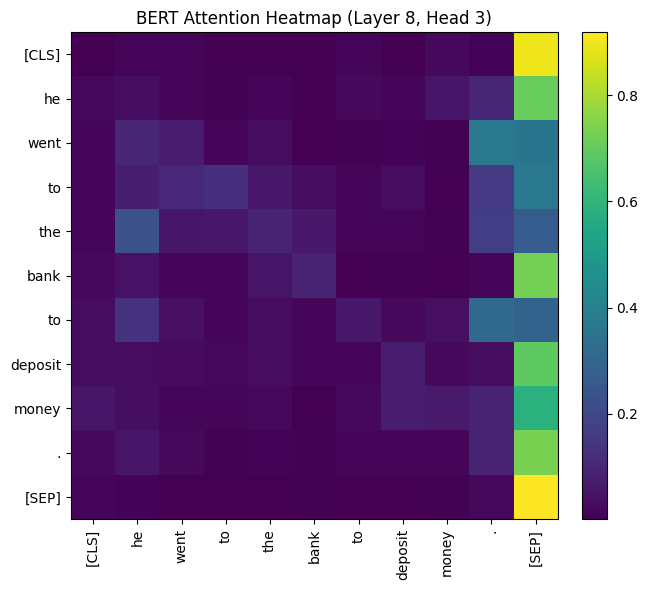

In [7]:
import matplotlib.pyplot as plt
import numpy as np

layer_idx = 8   # try deeper layer to see more semantic patterns
head_idx  = 3   # pick any head to visualize

mat = attentions[layer_idx][0, head_idx].detach().cpu().numpy()  # (seq_len, seq_len)

plt.figure(figsize=(7, 6))
plt.imshow(mat)  # values in [0,1]
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(f"BERT Attention Heatmap (Layer {layer_idx}, Head {head_idx})")
plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
plt.tight_layout()
plt.show()

# Interpretation tip:
# - Row i shows how token i distributes attention over all tokens (columns).
# - Brighter squares mean stronger attention weight to that token.


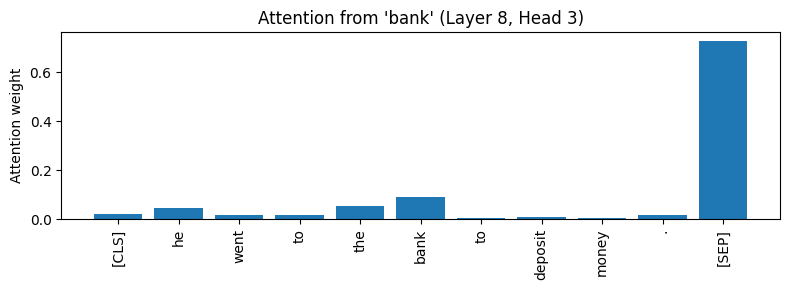

In [8]:
import numpy as np
import matplotlib.pyplot as plt

layer_idx = 8
head_idx = 3
src_token = "bank"   # change this to another token you'd like to probe

# Find the index of the token (first match). Note: tokenizer lowercases for 'uncased' models.
try:
    src_idx = tokens.index(src_token)
except ValueError:
    # If exact token not found, try WordPiece (e.g., '##bank' variants). Print tokens to inspect.
    print("Token not found directly. Available tokens:", tokens)
    raise

mat = attentions[layer_idx][0, head_idx].detach().cpu().numpy()  # (seq, seq)
weights = mat[src_idx]  # attention distribution from chosen token to all tokens

# Plot as a simple bar chart
plt.figure(figsize=(8, 3))
plt.bar(range(len(tokens)), weights)
plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
plt.title(f"Attention from '{tokens[src_idx]}' (Layer {layer_idx}, Head {head_idx})")
plt.ylabel("Attention weight")
plt.tight_layout()
plt.show()

# Interpretation tip:
# - Bars show which tokens the chosen token attends to most.
# - For ambiguous words (e.g., "bank"), attention often spikes on disambiguating context ("deposit", "money").
